In [6]:
from google.colab import files
import cv2
import numpy as np


In [7]:
# Upload input image
uploaded_input = files.upload()
input_image_path = list(uploaded_input.keys())[0]

Saving 20.jpg to 20 (2).jpg


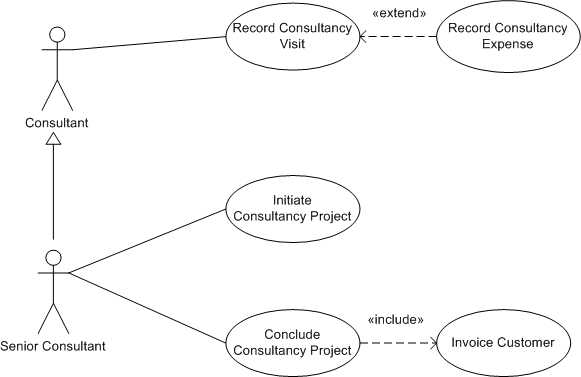

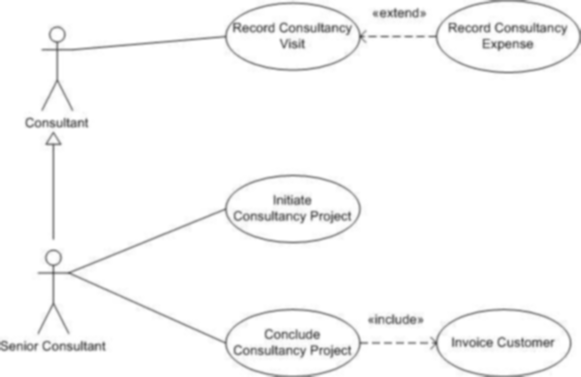

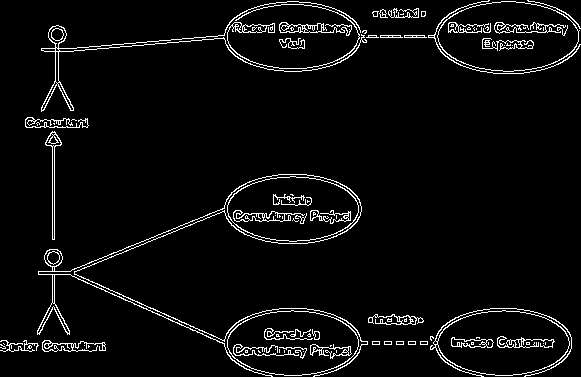

In [8]:
import cv2
from google.colab.patches import cv2_imshow

input_image = cv2.imread(input_image_path)

input_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

input_blurred = cv2.GaussianBlur(input_gray, (5, 5), 0)

input_edges = cv2.Canny(input_blurred, 50, 150)

cv2_imshow(input_gray)
cv2_imshow(input_blurred)
cv2_imshow(input_edges)

cv2.waitKey(0)
cv2.destroyAllWindows()


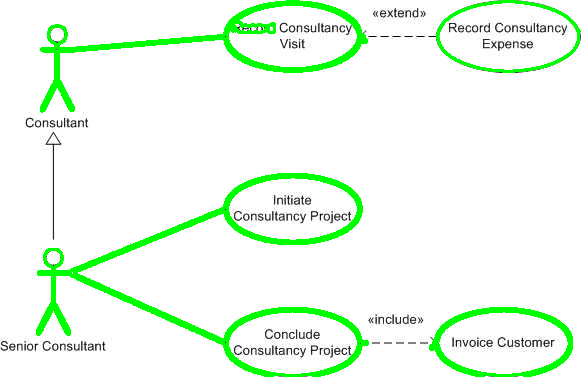

In [9]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def filter_contours(contours, min_size=100, aspect_ratio_range=(0.2, 5.0)):
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if cv2.contourArea(contour) > min_size and aspect_ratio_range[0] < (w / h) < aspect_ratio_range[1]:
            filtered_contours.append(contour)

    return filtered_contours

input_filtered_contours = filter_contours(cv2.findContours(input_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0])


input_contour_image = input_image.copy()
cv2.drawContours(input_contour_image, input_filtered_contours, -1, (0, 255, 0), 2)

cv2_imshow(input_contour_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [10]:
!pip install google-cloud-vision pillow

import os
import xml.etree.ElementTree as ET
from google.cloud import vision
from PIL import Image
from google.colab import drive, files
import re

# Mount Google Drive
drive.mount('/content/drive')

# Set the GOOGLE_APPLICATION_CREDENTIALS environment variable to the path in your Google Drive
credentials_path = '/content/drive/My Drive/Colab Notebooks/FYP/final-year-project-428305-b016400d8e0f.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

# Initialize Google Cloud Vision API client
client = vision.ImageAnnotatorClient()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
def parse_xml_annotation(xml_file):
    if not os.path.exists(xml_file):
        raise FileNotFoundError(f"The file {xml_file} does not exist.")

    try:
        tree = ET.parse(xml_file)
    except ET.ParseError as e:
        raise ValueError(f"Failed to parse XML file {xml_file}: {e}")

    root = tree.getroot()
    annotations = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        annotations.append({
            'class': class_name,
            'bbox': [xmin, ymin, xmax, ymax]
        })

    return annotations

def categorize_annotations(annotations):
    actors = []
    usecases = []
    includes = []
    extends = []
    associations = []

    for annotation in annotations:
        if annotation['class'] == 'actor':
            actors.append(annotation)
        elif annotation['class'] == 'usecase':
            usecases.append(annotation)
        elif annotation['class'] == 'include':
            includes.append(annotation)
        elif annotation['class'] == 'extend':
            extends.append(annotation)
        elif annotation['class'] == 'association':
            associations.append(annotation)

    return actors, usecases, includes, extends, associations

def extract_text_from_image(image_path, bbox):
    image = Image.open(image_path)
    cropped_image = image.crop(bbox)

    # Convert image to RGB if it has an alpha channel
    if cropped_image.mode == 'RGBA':
        cropped_image = cropped_image.convert('RGB')

    # Save the cropped image temporarily
    temp_image_path = "/tmp/temp_image.jpg"
    cropped_image.save(temp_image_path)

    # Read the image file into memory
    with open(temp_image_path, "rb") as image_file:
        content = image_file.read()

    # Use Google Cloud Vision API to detect text
    image = vision.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations

    if texts:
        text = texts[0].description.strip()
        # Keep only English letters, numbers, and common punctuation
        text = re.sub(r'[^A-Za-z0-9\s.,-]+', '', text)
        return text
    return ""

def display_information(actors, usecases, includes, extends, associations, image_path):
    actor_descriptions = []
    usecase_descriptions = []
    include_descriptions = []
    extend_descriptions = []
    association_descriptions = []

    for actor in actors:
        actor_text = extract_text_from_image(image_path, actor['bbox'])
        actor_descriptions.append(actor_text)

    for usecase in usecases:
        usecase_text = extract_text_from_image(image_path, usecase['bbox'])
        usecase_descriptions.append(usecase_text)

    for include in includes:
        include_text = extract_text_from_image(image_path, include['bbox'])
        include_descriptions.append(include_text)

    for extend in extends:
        extend_text = extract_text_from_image(image_path, extend['bbox'])
        extend_descriptions.append(extend_text)

    for association in associations:
        association_text = extract_text_from_image(image_path, association['bbox'])
        association_descriptions.append(association_text)

    print("Actors:")
    for actor_text in actor_descriptions:
        print(f" - {actor_text}")

    print("\nUse Cases:")
    for usecase_text in usecase_descriptions:
        print(f" - {usecase_text}")

    return actor_descriptions, usecase_descriptions, include_descriptions, extend_descriptions, association_descriptions

def find_closest_pairs(includes, extends, associations, actors, usecases, image_path):
    closest_pairs = []

    for include in includes:
        closest_pair = find_two_closest(include, actors + usecases, image_path)
        closest_pairs.append(('include', closest_pair))

    for extend in extends:
        closest_pair = find_two_closest(extend, actors + usecases, image_path)
        closest_pairs.append(('extend', closest_pair))

    for association in associations:
        closest_pair = find_two_closest(association, actors + usecases, image_path)
        closest_pairs.append(('association', closest_pair))

    print("\nClosest Relationships:")
    for rel_type, pair in closest_pairs:
        if pair:
            print(f"\n{rel_type.capitalize()}:")
            print(f" - {pair[0]} <-> {pair[1]}")

    return closest_pairs

def find_two_closest(relationship, group, image_path):
    relationship_center = get_center(relationship['bbox'])
    closest_elements = []
    min_distances = []

    for item in group:
        item_center = get_center(item['bbox'])
        distance = calculate_distance(relationship_center, item_center)
        if len(closest_elements) < 2:
            closest_elements.append(item)
            min_distances.append(distance)
        else:
            max_distance_index = min_distances.index(max(min_distances))
            if distance < min_distances[max_distance_index]:
                closest_elements[max_distance_index] = item
                min_distances[max_distance_index] = distance

    if len(closest_elements) == 2:
        text1 = extract_text_from_image(image_path, closest_elements[0]['bbox'])
        text2 = extract_text_from_image(image_path, closest_elements[1]['bbox'])
        return (text1, text2)
    return None

def get_center(bbox):
    x1, y1, x2, y2 = bbox
    return ((x1 + x2) / 2, (y1 + y2) / 2)

def calculate_distance(point1, point2):
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

# Upload XML and Image files
uploaded = files.upload()
xml_file = list(uploaded.keys())[0]

uploaded = files.upload()
image_file = list(uploaded.keys())[0]

# Debugging: Print current working directory and check file existence
print("Current working directory:", os.getcwd())
print("Trying to access file:", xml_file)
print("File exists:", os.path.exists(xml_file))

annotations = parse_xml_annotation(xml_file)
actors, usecases, includes, extends, associations = categorize_annotations(annotations)

actor_descriptions, usecase_descriptions, include_descriptions, extend_descriptions, association_descriptions = display_information(actors, usecases, includes, extends, associations, image_file)
closest_pairs = find_closest_pairs(includes, extends, associations, actors, usecases, image_file)


Saving download (8).xml to download (8) (1).xml


Saving download (8).png to download (8) (1).png
Current working directory: /content
Trying to access file: download (8) (1).xml
File exists: True
Actors:
 - Consultant
 - Senior Consultant

Use Cases:
 - Record Consultancy
Visit
 - Initiate
Consultancy Project
 - Conclude
Consultancy Project
 - Record Consultancy
Expense
 - Invoice Customer

Closest Relationships:

Include:
 - Conclude
Consultancy Project <-> Invoice Customer

Extend:
 - Record Consultancy
Expense <-> Record Consultancy
Visit

Association:
 - Consultant <-> Record Consultancy
Visit

Association:
 - Consultant <-> Senior Consultant

Association:
 - Initiate
Consultancy Project <-> Senior Consultant

Association:
 - Conclude
Consultancy Project <-> Senior Consultant
